# Assignment Set 8
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU

In [5]:
#@title Data Injection
#@markdown here we also do the train test split
test_size = 0.35 #@param {type:"slider", min:0.10, max:0.35, step:0.01}
x = pd.read_csv('data/housing.csv').dropna()
y = x.pop('median_house_value')
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size)

##Cleaning Data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



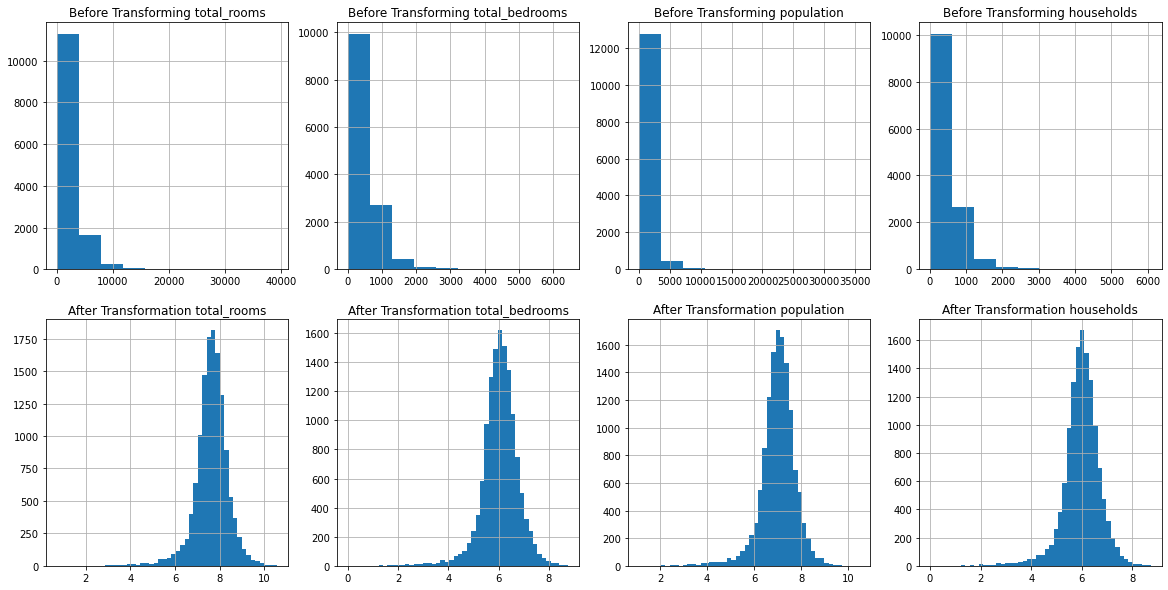

In [6]:
#@title total_rooms + total_bedrooms + population
plt.figure(figsize=(20,10))
for i,idx in enumerate(['total_rooms',
                        'total_bedrooms',
                        'population',
                        'households']):
    ax = plt.subplot(2,4,i+1)
    ax.set_title('Before Transforming '+idx)
    x_train.loc[:,idx].hist()

    ax = plt.subplot(2,4,i+5)
    ax.set_title('After Transformation '+idx)
    x_train.loc[:,idx] = np.log(x_train.loc[:,idx])
    x_test.loc[:,idx] = np.log(x_test.loc[:,idx]) # in the transformation pipeline
    x_train.loc[:,idx].hist(bins=50)
plt.show()

In [ ]:
#@title ocean_proximity ordinal encoding
mapping = {'<1H OCEAN': 5, 
           'INLAND': 4,
           'ISLAND': 1,
           'NEAR BAY': 2,
           'NEAR OCEAN': 3}
x_train['ocean_proximity'] = x_train['ocean_proximity'].astype('category').map(mapping).astype('float')
x_test['ocean_proximity'] = x_test['ocean_proximity'].astype('category').map(mapping).astype('float') # in the transformation pipeline

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # in the transformation pipeline
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.1)

## Second Keras Model With Different Optimizers

In [12]:
stride = 4
epochs =  50#@param {type:"integer"}
verbose =  0#@param {type:"number"}
mdl_pool = {}
for item in 'Adam','RMSprop','Adadelta','SGD':
    name = 'clf_l2_'+item
    
    inputs = layers.Input(shape=(9))
    l_ = layers.Dense(16,activation='linear')(inputs)

    for i in range(16):
        l_ = layers.Dense(16,activation='linear',kernel_regularizer=regularizers.l2(5e-1))(l_)
        l_ = layers.Reshape((-1,1))(l_)
        l_ = layers.MaxPooling1D(pool_size=stride,strides=stride)(l_)
        l_ = layers.Flatten()(l_)
        
    l_ = layers.Dense(8,activation='linear',kernel_regularizer=regularizers.l2(5e-1))(l_)
    l_ = layers.Dropout(.3)(l_)
    output = layers.Dense(1)(l_)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model.compile(loss='mse',
            optimizer=item)
    
    mdl_pool[name] = model.fit(x = x_train, y = y_train,
                            batch_size=64, epochs=epochs,
                            verbose=verbose,validation_data=(x_val,y_val),
                            use_multiprocessing=True,
                            workers=-1,
                            validation_batch_size = 64).history
    mdl_pool[name]['eval'] = model.evaluate(x_test, y_test)

202/202 [==============================] - 1s 2ms/step - loss: nan


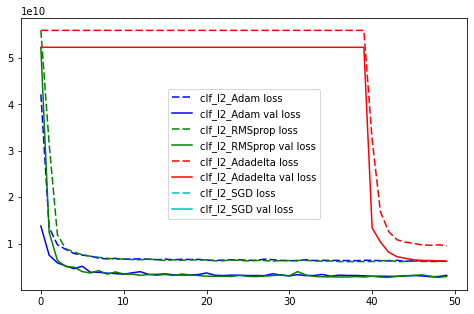

In [13]:
#@title Plot Training History
plt.figure(figsize=(8,5))
c = ['b', 'g', 'r', 'c']
for i,(name,item) in enumerate(mdl_pool.items()):
    # if 'SGD' in name: # sdg produced inf values!
    #     continue
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()

In [16]:
#@title Evaluation of The Models Trained With Different Optimizers
for n,v in mdl_pool.items():
    print(n)
    print('\tloss',v['eval'])
    print('\taccuracy',v['eval'])

clf_l2_Adam
	loss 4065743872.0
	accuracy 4065743872.0
clf_l2_RMSprop
	loss 3823651328.0
	accuracy 3823651328.0
clf_l2_Adadelta
	loss 7302834176.0
	accuracy 7302834176.0
clf_l2_SGD
	loss nan
	accuracy nan
